### 1. Preprocessing

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from preprocessing import combine_data_frompath

In [2]:
train_data = combine_data_frompath('aug_data\\train\\labels\\*.json','aug_data\\train\\images\\*.jpg')
val_data = combine_data_frompath('aug_data\\val\\labels\\*.json','aug_data\\val\\images\\*.jpg')

### 2. Example Output

In [ ]:
res = train_data.as_numpy_iterator().next()


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 3. Create Model

In [3]:
from model import FaceTracker, gradient
facetracker = FaceTracker()

In [ ]:
facetracker.load_weights("./checkpoints/my_checkpoint")

### 4. Callbacks
I will add this soon

In [ ]:
optimizer = tf.keras.optimizers.Adam
run_time = 1
log_dir = "logs/fit/" + datetime.strftime(datetime.now(),
                                        "%Y/%m/%d-%H/%M")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                        patience=5)

checkpoint_path = f"checkpoint/training_{run_time}/cp.ckpt"
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        verbose=1)

In [ ]:
def lr_scheduler(epoch,lr):
    if epoch//5 == 0:
        return lr*0.5
    return lr
lr_callback = callbacks.LearningRateScheduler(lr_scheduler)

### 5. Train Model

In [4]:
num_epochs = 10
batches_per_epoch = len(train_data)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=lr_decay)

In [5]:
train_loss_results = []
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    #epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for x,y in train_data:
        loss_value, grads = gradient(facetracker,x,y)
        opt.apply_gradients(zip(grads, facetracker.trainable_variables))
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        #epoch_accuracy.update_state(y, facetracker(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    #train_accuracy_results.append(epoch_accuracy.result())
    

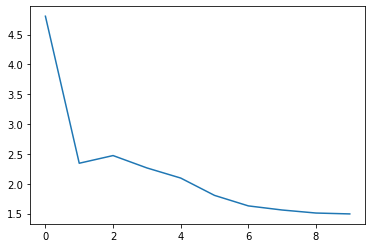

In [6]:
plt.plot(np.arange(num_epochs),np.array(train_loss_results))

### 6. Test Model

In [7]:
facetracker.save_weights('./checkpoints/my_checkpoint')

In [8]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()